# Example 1: What price should I sell my used iphone for?
* This exmaple is taken from  http://www.statsathome.com/2017/10/12/bayesian-decision-theory-made-ridiculously-simple/

### Task
* Decide for price for a phone from 2014 without scratches

### Todo:
* Excurs to shared variables in pymc3
* Make contour plots and refine the problem

In [12]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from matplotlib import pyplot as plt
from functools import partial
from scipy.special import expit
from scipy.optimize import minimize_scalar
import pymc3 as pm
% matplotlib inline

In [3]:
train = pd.DataFrame({"sold": [1, 1, 0, 0, 1, 1], 
                     "scratched": [0, 0, 1, 0, 0, 0], 
                     "year": [2014, 2015, 2010, 2014, 2015, 2016],
                     "price": [50, 70, 40, 100, 90, 100]})
train

,price,scratched,sold,year
0,50,0,1,2014
1,70,0,1,2015
2,40,1,0,2010
3,100,0,0,2014
4,90,0,1,2015
5,100,0,1,2016


### The model
$$
\begin{align}
y_{\text{sold}, i} &\sim \text{Bernoulli}(\pi_i) \\
\pi_i &\sim \text{logit}^{-1}(\eta_i) \\
\eta_i &\sim \beta_0 + \beta_1 \text{scratched}_i + \beta_2 \text{year_i} + \beta_3 \text{price}_i
\end{align}
$$

### Priors
$$
\begin{align}
\beta_0 &\sim \text{Uniform} \\ 
\beta_1 &\sim \mathcal N(-1, 1) \\
\beta_2 &\sim \mathcal N(1, 1) \\
\beta_3 &\sim \mathcal N(-2, 1) 
\end{align}
$$


### Utility function
* We need to decide at what price we would like to sell the phone
* So the price is our decision space
* $$U(price, \pi) = price \, \pi$$

### Expected utility function
$$ U(price) = \left \langle U(price, \pi)  \right \rangle _ {p(\pi)}$$



### Next Steps
* Instead of year take feature "years old"
* Include interaction terms
* Use GLM syntax

In [3]:
def get_intial_test_values(model: pm.Model):
    for RV in model.basic_RVs:
        print(RV.name, RV.logp(model.test_point))

def inspect_model(trace):
    pm.traceplot(trace)
    print(pm.summary(trace))
    
    

In [4]:
with pm.Model() as logistic:
    Intercept = pm.Uniform("Intercept", -7000, -1000)
    scratched = pm.Normal("scratched", mu=-1, sd=1)
    year = pm.Normal("year", mu=1, sd=1)    
    price = pm.Normal("price", mu=-2, sd=1) 
    pi = pm.math.invlogit(Intercept + scratched * train.scratched + year * train.year + price * train.price)
    likelihood = pm.Bernoulli('likelihood', pi, observed=train.sold)
    trace_logistic = pm.sample(chains=1, tune=1000, samples=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [price, year, scratched, Intercept_interval__]
100%|██████████| 1500/1500 [01:50<00:00, 13.58it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


                  mean           sd    mc_error      hpd_2.5     hpd_97.5
scratched    -1.218711     1.099856    0.093605    -3.090399     0.850129
year          2.319582     0.603730    0.058382     1.319982     3.432767
price        -0.130225     0.075182    0.006688    -0.288332     0.004240
Intercept -4660.089803  1213.765588  117.361210 -6865.675368 -2623.381877


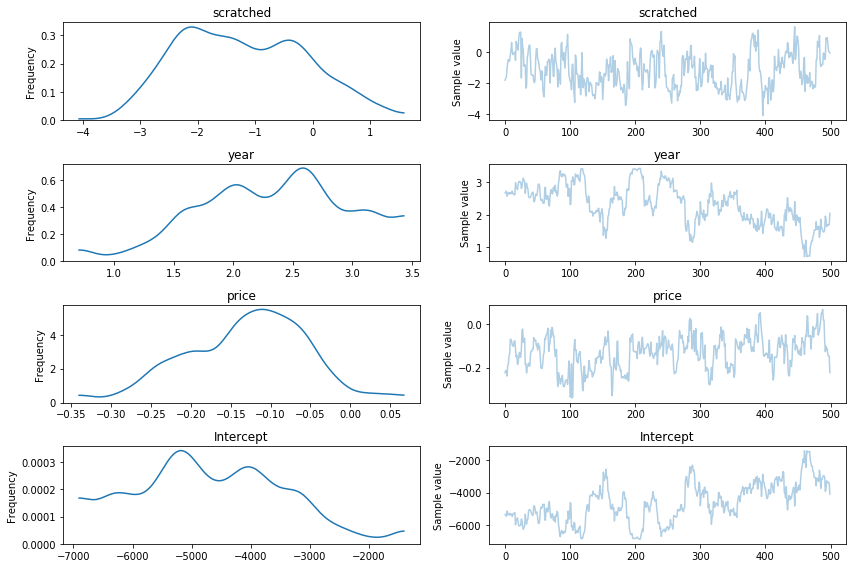

In [5]:
inspect_model(trace_logistic)

In [6]:
def predict(price, scratched, year, trace):
    linear = trace['Intercept'] + trace['scratched'] * scratched + trace['year'] * year + trace['price'] * price
    return expit(linear)

# probabilities for given phone
buy_probability = partial(predict, trace=trace_logistic, scratched=0, year=2014)

# expected utility function
expected_utility = lambda price: price.flatten() * buy_probability(price).mean(axis=1)

# Numerical optimum
optimum = minimize_scalar(lambda x: -expected_utility(np.array([[x]])).flatten()[0])['x']

** First we habe a quick look at the pdf relevant pdf

Text(0.5,0,'price')

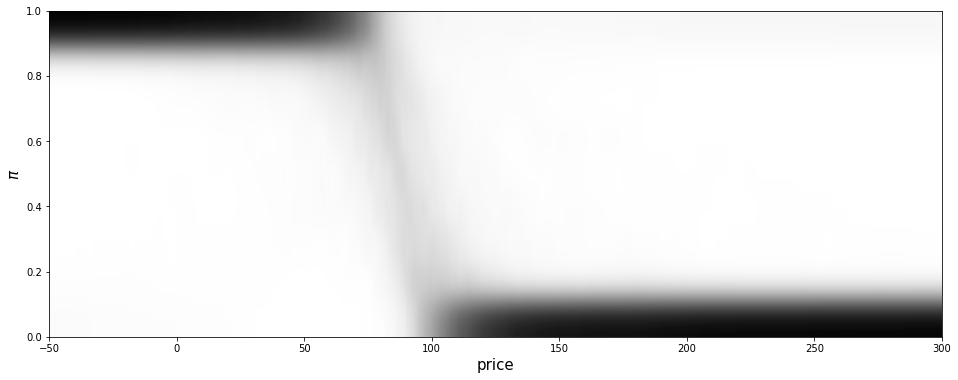

In [7]:
prices = np.arange(-50, 300)
bins = np.linspace(0, 1, 10, endpoint=True)
pis = bins[1:]
pdf = np.zeros((len(prices), len(pis)))
for p in range(len(prices)):
    hist, _ = np.histogram(buy_probability(prices[p]), bins=bins)
    pdf[p, :] = hist
X, Y = np.meshgrid(prices, pis)
fig, ax = plt.subplots(figsize=(16,6))
ax.imshow(pdf.transpose(), 
          interpolation='gaussian', 
          cmap=plt.cm.binary,
          aspect='auto', 
          origin='lower', 
          extent=(-50, 300, 0, 1), 
          vmax=pdf.max(), 
          vmin=0)
ax.set_ylabel(r"$\pi$", fontsize=15)
ax.set_xlabel(r"price", fontsize=15)

* Instead of the pdf we typically consider only point estimates (mean. interquartil distances etc) for visualization

* Furthermore, we can incorporate the utility function and find it's optimum

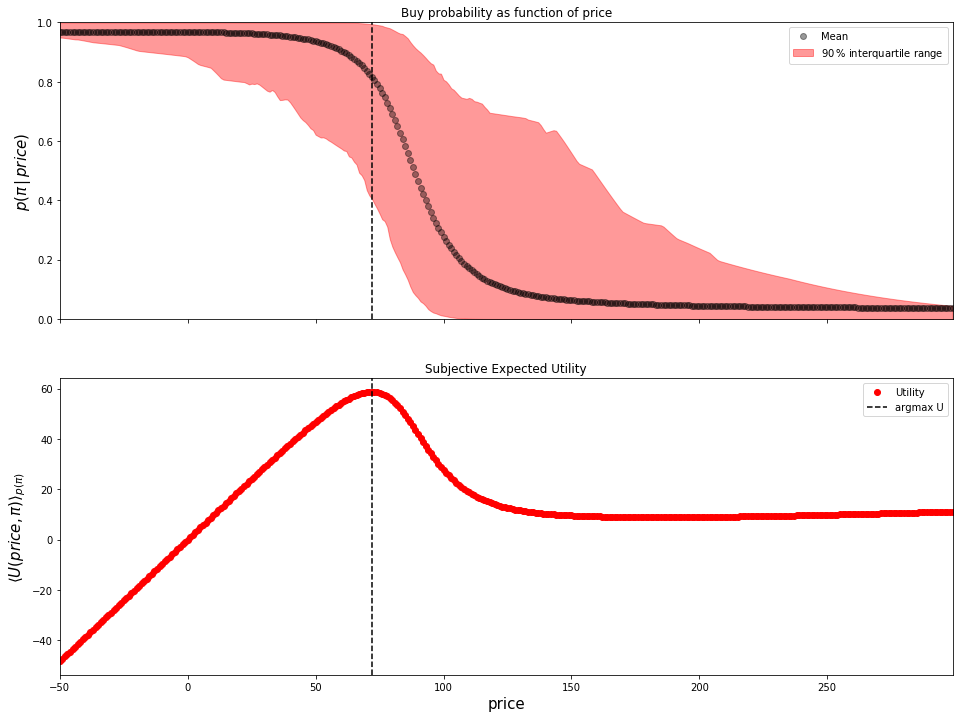

In [8]:
import numpy as np
prices = np.arange(-50, 300)[:,None]
probs = buy_probability(prices)
fig, ax = plt.subplots(nrows=2, figsize=(16,12), sharex=True)
ax[0].plot(prices, probs.mean(axis=1), 'o', color='black', alpha=0.4, label="Mean")
ax[0].fill_between(prices.flatten(), 
                np.percentile(probs, 5, axis=1), 
                np.percentile(probs, 95, axis=1), 
                color='red', 
                alpha=.4, 
                label=r"$90\,\%$ interquartile range")
ax[0].axvline(optimum, ls="--", color="black")
ax[0].set_ylabel(r"$p(\pi\,|\,price)$", fontsize=15)
ax[0].set_title("Buy probability as function of price")
ax[0].set_xlim(prices.min(), prices.max())
ax[0].set_ylim(0,1)
ax[0].legend()
ax[1].plot(prices, expected_utility(prices), "o", color="red", label="Utility")
ax[1].axvline(optimum, ls="--", color="black", label="argmax U")

ax[1].set_title("Subjective Expected Utility")
ax[1].set_ylabel(r"$\left \langle U(price, \pi)\right\rangle_{p(\pi)}$", fontsize=15)
ax[1].set_xlabel("price",  fontsize=15)
ax[1].legend();

#### Remark:
* Actually the definition of the utility function is not very intuitive!
* Alternatively one could set the utility as
%\text{price if bought and zero if not bought}

* $$
\begin{align}
U(price, bought) = 
\begin{cases}
price, ~ &\text{if } bought=1\\
0 , &\text{if } bought=0
\end{cases}
\end{align}
$$
* This eventually leads to the very same formula as we have seen it
* The expected Utility then reads
* $$U(price) = \sum_{bought} U(price, bought) p(bought | year, scratched)$$,
* where the sum goes over all states of bought (1=True, 0=False). Since for no buy the utility function is zero
this simplifies to
* $$U(price) = U(price, bought=1) p(bought=1\,|\,year, scratched)$$
* The conditional probability can be optained by Bayes Theorem or by sampling
* Note that we could also consider instead $p(bought)$. This would correspond to not caring about the state of the phone. It should give different results!

**TODO** 
* Work out difference between known states of phones to sell (year, scratched) vs unknown state of the phone
* Work out joint pdf vs conditional pdf in the probs


# Example 2: Shall I take the bus?

### The problem:
* Assume that you need to go to work. You could either take the bus right in front of your door, or take the bike. 
* The bus ride takes 10 mins, whereas you need 20 mins by bike.
* Since you are not a native early bird, you don't have any knowledge about the bus schedule - but you do have some data for bus waiting times (which you collected)
* Now, you need to decide if to wait for the bus or to take the bike. 
* Since we live in the new work era, assume that the time you spent for going to work just corresponds to the amount of money you would have earned (assuming that you earn 1 dollar per minute). The bus ride costs you 3 $ but riding your bike is free


### Utility function:
* Let's setup the Utility function, which depends on
* Decision $d$ (bike or bus)
* Waiting time on the bus stop $t$
$$
\begin{align}
U(d, t) = 
\begin{cases}
10 + 3 + t, ~ &\text{if } d=bus\\
20 , &\text{if } d=bike
\end{cases}
\end{align}
$$

### Expected Utility function
* We need to take the expectation value w.r.t $t$ of the Utility function:
$$U(t) = \int U(d, t) p(t)\,dt$$
* Assume that we have inferred a model from the data that depends on other RVs, say $\theta$ with joint pdf $p(t, \theta)$
* Thus, we need first marginalize out the other RVs - $p(t) = \int d\theta\, p(t, \theta)$ -  in order to compute the Expected Utility function
$$U(t) = \int dt\, \int d\theta \, U(d, t) p(t, \theta) $$
* **Alternatively we may rewrite** the joint as $p(t, \theta) = p(t\, |\,\theta) p(\theta)$ and arrive at the expression:
$$U(t) = \int d\theta \,  \int dt\, U(d, t) p(t\,|\,\theta) p(\theta)$$
So in this representation we would first compute the expected Utility function w.r.t the conditionals and then take the expectation value w.r.t to the (latent) $\theta$ variables.


* **Note:** with this setup we want to _minmize_ the expected utility function. 

### Data generating process
* Let's play god for a while and assume that the waiting time corresponds to an exponential distribution with expectation time of 4 mins

### First simple approach



In [13]:
def generate_waiting_times(mean: float, size):
    return pd.DataFrame({'waiting_time': np.round(np.random.exponential(scale=mean, size=size))})

In [14]:
waiting_times = generate_waiting_times(10, 5)
waiting_times

,waiting_time
0,20.0
1,28.0
2,27.0
3,0.0
4,20.0


In [15]:
with pm.Model() as exponential_model:
    scale = pm.Uniform('scale', upper=30, lower=0, testval=6)
    waiting_time = pm.Exponential("waiting_time", 1/scale, observed=waiting_times.waiting_time)
    exponential_model_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [scale_interval__]
100%|██████████| 1000/1000 [00:00<00:00, 1461.21it/s]
The acceptance probability does not match the target. It is 0.9193373773946572, but should be close to 0.8. Try to increase the number of tuning steps.


#### Remark: 
* For this simple model we don't really need to perform MCMC computations
* Instead one could solve the problem analytically by using the Gamma distribution as conjugate prior to the exponential distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab0f046da0>,
      dtype=object)

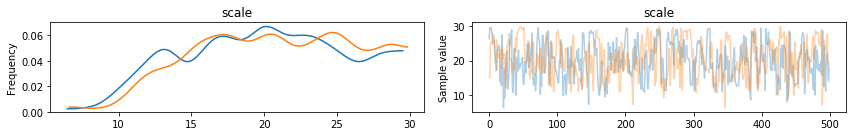

In [17]:
#inspect_model(exponential_model_trace)
pm.traceplot(exponential_model_trace)

In [19]:
def utility(decision, waiting_time):
    if decision == "bike":
        return 20 * np.ones(waiting_time.shape)
    if decision == "bus":
        return 10 + waiting_time + 3

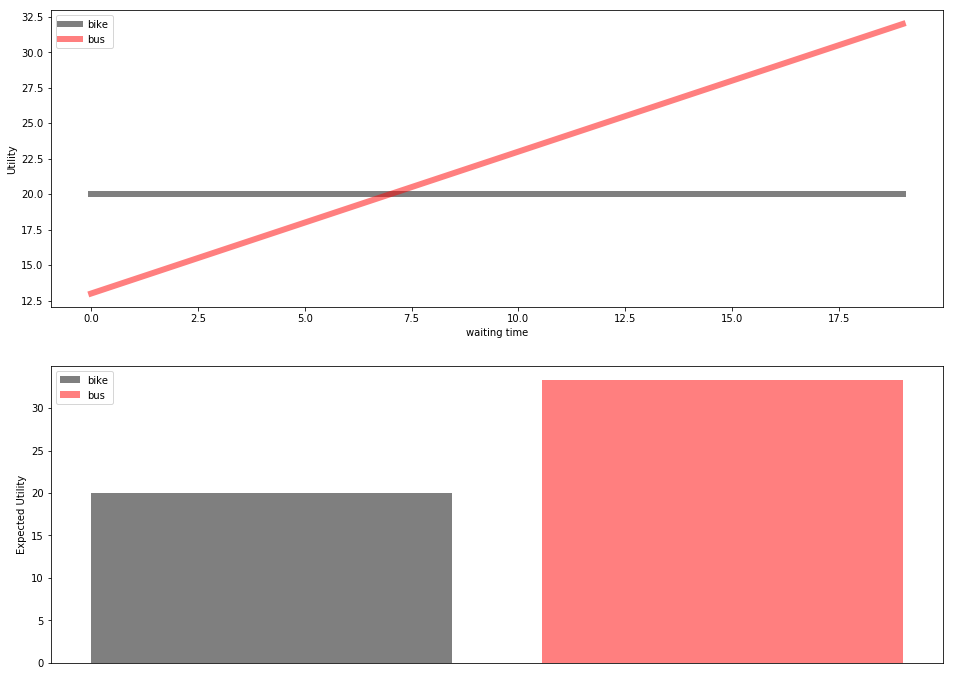

In [20]:
fig, ax = plt.subplots(nrows=2, figsize=(16,12))
ax[0].set_xlabel("waiting time")
ax[0].set_ylabel("Utility")
times = np.arange(20)
ax[0].plot(times, utility("bike", times), color="black", lw=6, alpha=.5, label="bike")
ax[0].plot(times,  utility("bus", times), color="red", lw=6, alpha=.5, label="bus")
ax[0].legend();
ax[1].set_ylabel("Expected Utility")
ax[1].bar(0,  utility("bike", np.ones(1)), color="black", alpha=0.5, label="bike")
ax[1].bar(1,  utility("bus", exponential_model_trace.scale).mean(), color="red", alpha=0.5, label="bus")
ax[1].legend()
ax[1].set_xticks([]);

### look at overall behavior
* Let's have a look on how the decision changes with increasing data with increasing data!

In [21]:
from collections import namedtuple
bus_ride = namedtuple("busride", ["data", "trace", "mean", "hpd_025", "hpd_975", "bus_utility"])

In [22]:
waiting_times = generate_waiting_times(6, 1000)

In [23]:
chunks = [waiting_times[:i] for i in [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 500, 1000]]
results = []

for chunk in chunks:
    with pm.Model() as exponential_model:
        scale = pm.Uniform('scale', upper=30, lower=0, testval=6)
        waiting_time = pm.Exponential("waiting_time", 1/scale, observed=chunk.waiting_time)
        traces = pm.sample(tune=1500, samples=3000)
    summary = pm.summary(traces).loc['scale']
    trace = traces["scale"]
    result = bus_ride(data=chunk,
                      trace = trace, 
                      mean = summary["mean"], 
                      hpd_025 = summary["hpd_2.5"],
                      hpd_975 = summary["hpd_97.5"],
                      bus_utility = utility("bus", trace).mean())
    results.append(result)
    

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [scale_interval__]
INFO:pymc3:NUTS: [scale_interval__]
100%|██████████| 2000/2000 [00:01<00:00, 1454.58it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chain

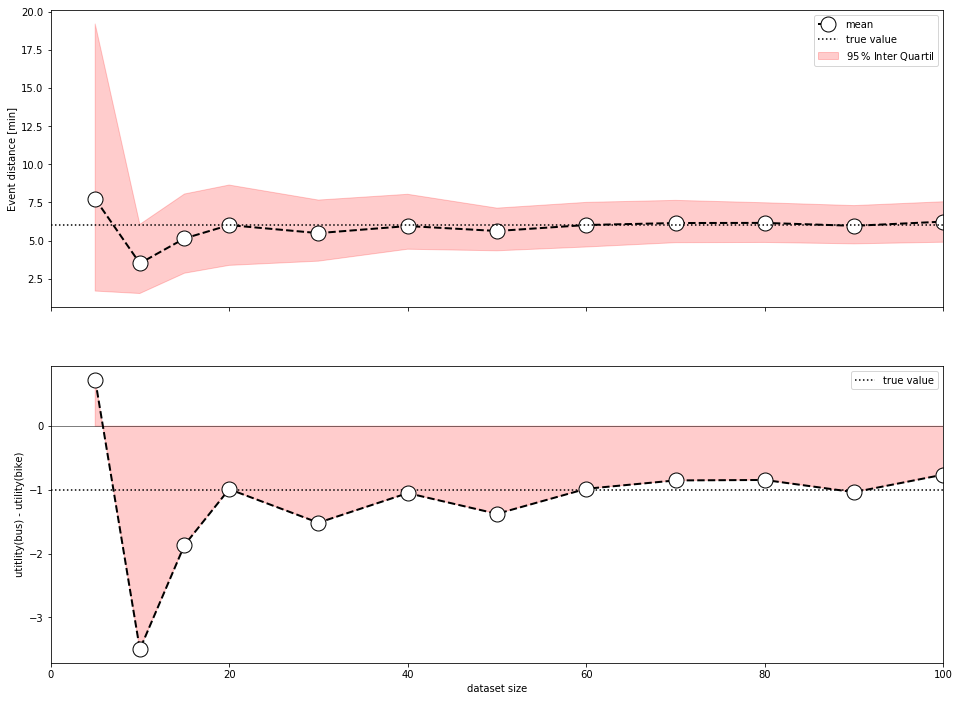

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=(16,12), sharex=True)
datasize = list(map(lambda x: len(x.data), results))
mean = list(map(lambda x: x.mean, results))
hpd_low = list(map(lambda x: x.hpd_025, results))
hpd_high = list(map(lambda x: x.hpd_975, results))
bus_minus_bike_utility = list(map(lambda x: x.bus_utility - 20, results))
ax[0].plot(datasize, mean, 'o--', color='black', alpha=1, ms=15, lw=2, markerfacecolor="white", label="mean")
ax[0].fill_between(datasize, hpd_low, hpd_high, color="red", alpha=.2, label=r"$95\,\%$ Inter Quartil")
ax[0].axhline(6, color="black", ls=":", label="true value")
ax[0].set_xlim(0, 100)
ax[0].set_ylabel("Event distance [min]")
ax[0].legend()
ax[1].axhline(0, ls="-", lw=.5, color="black")
ax[1].axhline(-1, ls=":", color="black", label="true value")
ax[1].plot(datasize, bus_minus_bike_utility, "o--", color="black", lw=2, ms=15, markerfacecolor="white")
ax[1].fill_between(datasize, bus_minus_bike_utility, color="red", alpha=.2)
ax[1].set_ylabel("utitlity(bus) - utility(bike)")
ax[1].set_xlabel("dataset size")
ax[1].legend()



### Discussion


# Example 3: Fashion retailers


In [96]:
t = pd.read_csv("resources/data_fashion_retailer.csv", 
                dtype={"returns_too_small":np.int64, "returns_too_large":np.int64})
t.dtypes

buys                  int64
returns               int64
returns_too_small     int64
returns_too_large     int64
product_id           object
dtype: object